https://www.kaggle.com/screech/ensemble-of-arima-and-lstm-model-for-wiki-pages

In [ ]:
!pip install pmdarima

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
from numpy import log
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation
import category_encoders as ce

import os
import sys
import re

import random
import math
import time

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot # to visualize and configure the parameters of ARIMA model
from statsmodels.tsa.arima_model import ARIMA # to make an ARIMA model that fits the data


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/E4/Projet\ Seq2seq

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/E4/Projet Seq2seq


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv("./web-traffic-time-series-forecasting/train_1.csv").fillna(0)
# df.head()
print("Shape: ", df.shape)
df[:]

Shape:  (145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'na'

df['lang'] = df.Page.map(get_language) #ajoute une colonne langue

print(df.lang[:10])
print(Counter(df.lang))

0    zh
1    zh
2    zh
3    zh
4    zh
5    zh
6    zh
7    zh
8    zh
9    zh
Name: lang, dtype: object
Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [ ]:
def get_access_agent(page):
    # res = re.search('wikipedia.org_([a-z_-]+?)', page)
    # res = re.compile("wikipedia.org_(.*)$")
    res = re.search('wikipedia.org_(.*)', page)
    # print regexp.search(s).group(1)
    if res:
        # print("length: ",len(res[0]))
        # print(res.group(1))
        # print("group 2: ", res.search(page).group(2))
        return res.group(1) #res.search(page).group(1) #res[0][:]
    return 'na'

df['access_agent'] = df.Page.map(get_access_agent) #ajoute une colonne access-agent

print(df.access_agent[:10])
print(Counter(df.access_agent))

0    all-access_spider
1    all-access_spider
2    all-access_spider
3    all-access_spider
4    all-access_spider
5    all-access_spider
6    all-access_spider
7    all-access_spider
8    all-access_spider
9    all-access_spider
Name: access_agent, dtype: object
Counter({'all-access_all-agents': 35099, 'mobile-web_all-agents': 30923, 'all-access_spider': 30614, 'desktop_all-agents': 30572, 'na': 17855})


In [ ]:
lang_sets = {}
lang_sets['en'] = df[df.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = df[df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = df[df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = df[df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = df[df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = df[df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = df[df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = df[df.lang=='es'].iloc[:,0:-1]

# access_agent_sets = {}
lang_sets['all-access_all-agents'] = df[df.access_agent=='all-access_all-agents'].iloc[:,0:-1]
lang_sets['mobile-web_all-agents'] = df[df.access_agent=='mobile-web_all-agents'].iloc[:,0:-1]
lang_sets['all-access_spider'] = df[df.access_agent=='all-access_spider'].iloc[:,0:-1]
lang_sets['desktop_all-agents'] = df[df.access_agent=='desktop_all-agents'].iloc[:,0:-1]
lang_sets['na'] = df[df.access_agent=='na'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    print(lang_sets[key].iloc[:,1:-1])
    print(lang_sets[key].iloc[:,1:-1].sum(axis=0))
    sums[key] = lang_sets[key].iloc[:,1:-1].sum(axis=0) / lang_sets[key].shape[0]

# res = {} 
# for sub in access_agent_sets: 
#     for key, val in sub.items():  
#         res.setdefault(key, []).append(val) 

        2015-07-01  2015-07-02  2015-07-03  ...  2016-12-29  2016-12-30  2016-12-31
8357           3.0         4.0         7.0  ...         3.0         1.0         0.0
8358           0.0         0.0         0.0  ...      2302.0      2098.0      1770.0
8359           0.0         0.0         0.0  ...         0.0         1.0         2.0
8360        2403.0     20136.0      1850.0  ...      1681.0      1303.0      1098.0
8361         982.0       881.0       794.0  ...       393.0       354.0       272.0
...            ...         ...         ...  ...         ...         ...         ...
113946         1.0         5.0         2.0  ...         0.0         0.0         2.0
113947         7.0         9.0         3.0  ...         4.0         5.0         7.0
113948        10.0         6.0         4.0  ...         7.0        10.0         3.0
113949         0.0         0.0         1.0  ...         6.0         4.0         4.0
113950         8.0         5.0         7.0  ...        15.0        16.0     

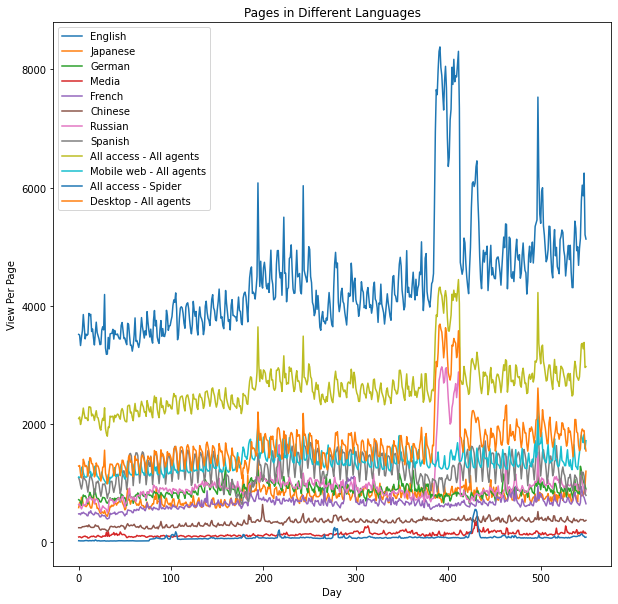

In [ ]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel('View Per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish',
        'all-access_all-agents':'All access - All agents','mobile-web_all-agents' : 'Mobile web - All agents', 'all-access_spider' : 'All access - Spider', 
         'desktop_all-agents' : 'Desktop - All agents'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

On vérifie si les séries sont stationnaires avec Augmented Dickey Fuller test. 

On doit avoir p value > 0.05 (significance level).

In [ ]:
original_df = pd.read_csv("./web-traffic-time-series-forecasting/train_1.csv", header=0, index_col=0, squeeze=True).fillna(0)
print(original_df.head())
result = adfuller( np.log(original_df.values[0])) #log the dataset to make the distriution of values more linear and better meet the expectations of this statistical test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

                                                    2015-07-01  ...  2016-12-31
Page                                                            ...            
2NE1_zh.wikipedia.org_all-access_spider                   18.0  ...        20.0
2PM_zh.wikipedia.org_all-access_spider                    11.0  ...        20.0
3C_zh.wikipedia.org_all-access_spider                      1.0  ...        17.0
4minute_zh.wikipedia.org_all-access_spider                35.0  ...        11.0
52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...         0.0  ...        10.0

[5 rows x 550 columns]
ADF Statistic: -5.022508
p-value: 0.000020
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


en


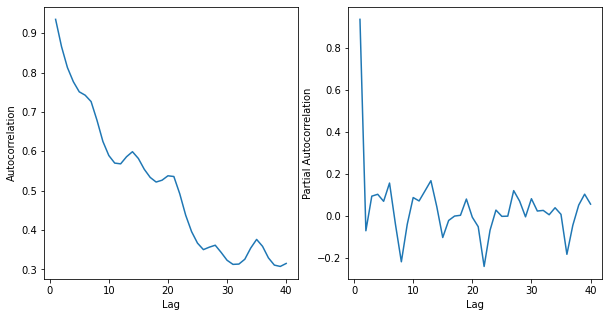

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


ja


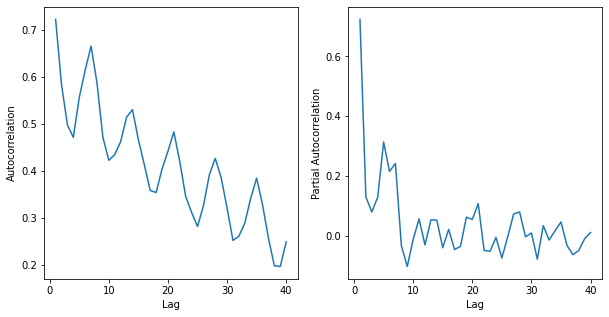

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


de


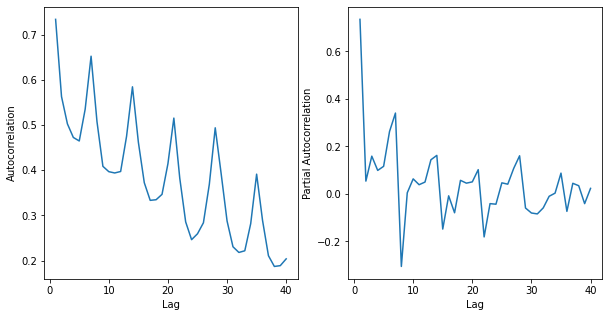

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


na


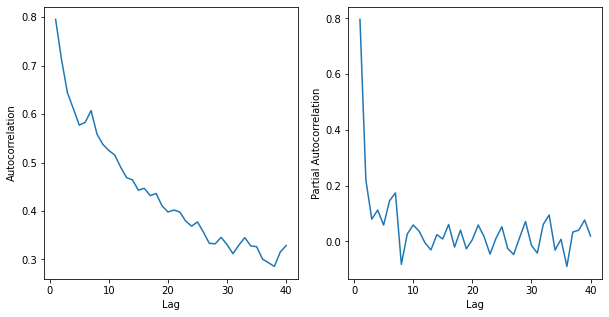

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


fr


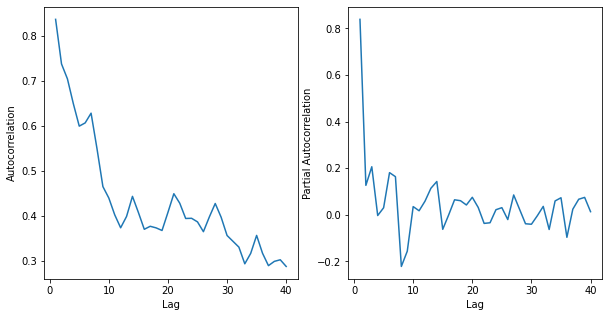

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


zh


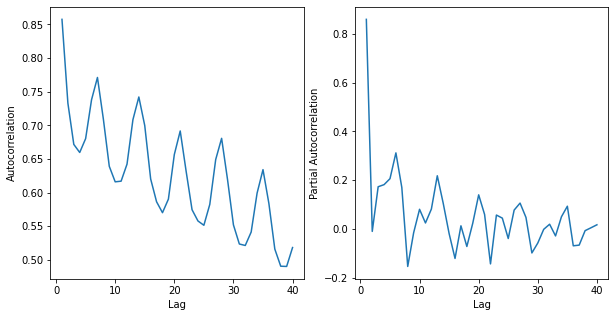

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


ru


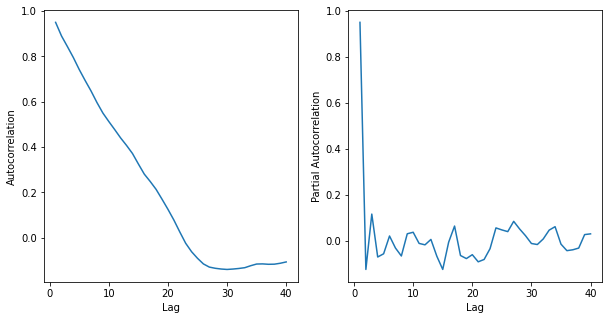

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


es


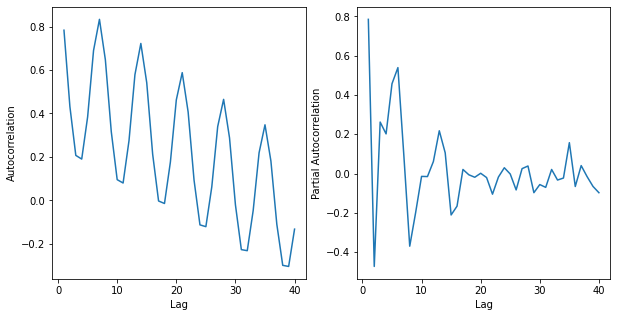

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


all-access_all-agents


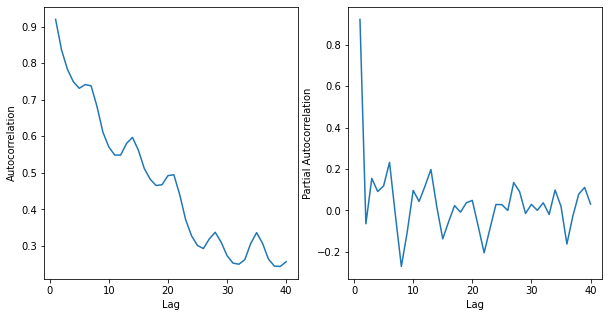

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


mobile-web_all-agents


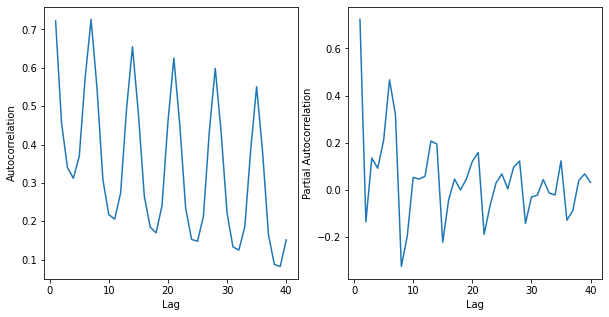

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


all-access_spider


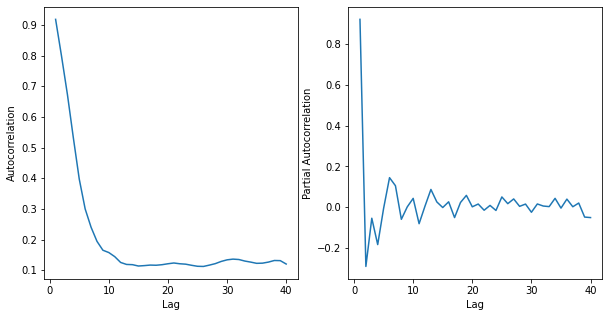

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


desktop_all-agents


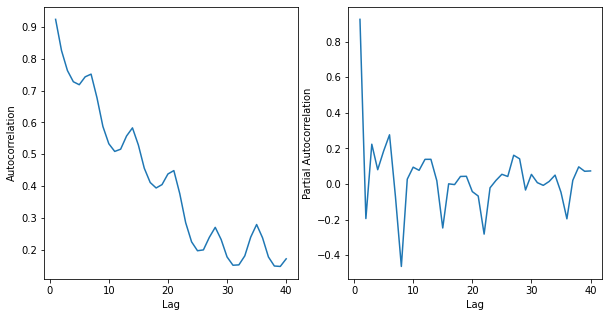

In [ ]:
#Autocorrelation and Partial Autocorrelation graphs to estimate the hyperparameters used in training the ARIMA model
for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

Pour en, ru, fr et na, nous n'avons pas besoin de differencing (d=0), alors que nous allons soustraire 1 de leur prédecesseur pour les autres (d=1).

Pour ja, de, zh, es il y a un pic après 7 jours donc nous utiliserons un lag de 7 et un lag de 4 pour les autres langues.

ARIMA model

en


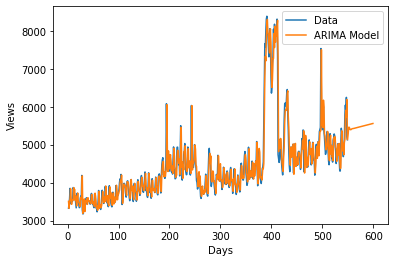

ja


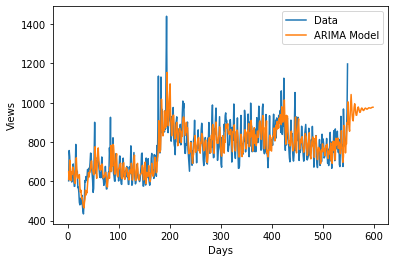

de


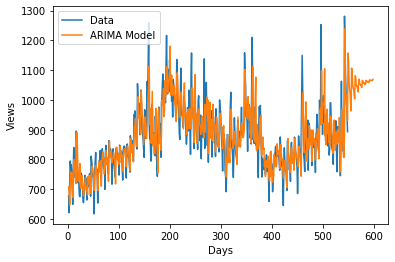

na


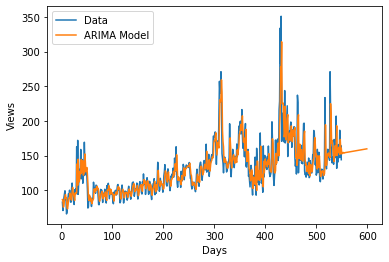

fr


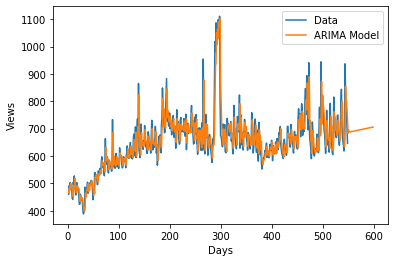

zh


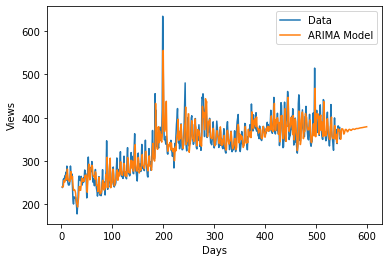

ru


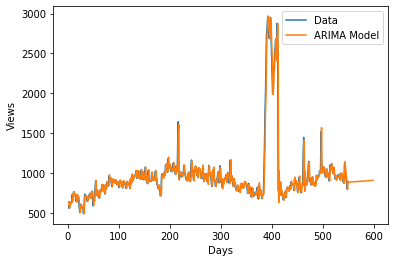

es


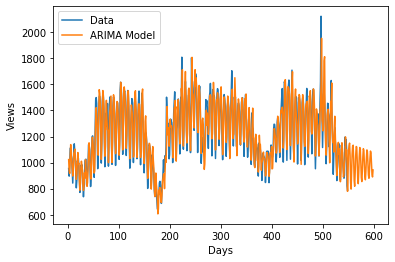

all-access_all-agents


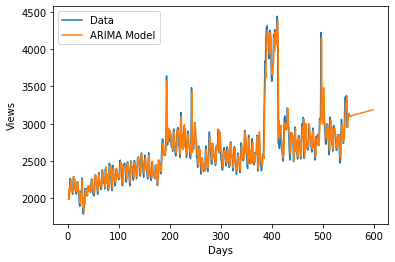

mobile-web_all-agents


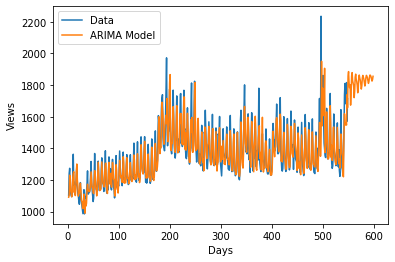

all-access_spider


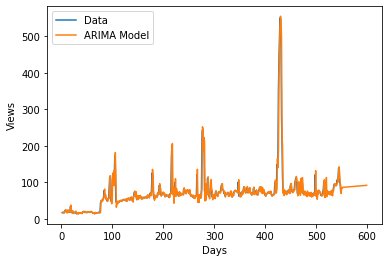

desktop_all-agents


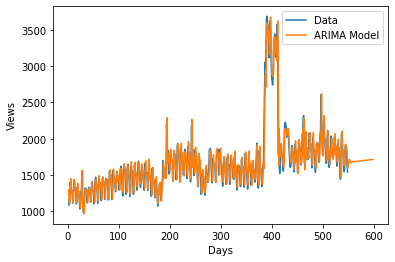

In [ ]:
params = {'en': [4,1,0], 'ja': [7,1,1], 'de': [7,1,1], 'na': [4,1,0], 'fr': [4,1,0], 'zh': [7,1,1], 'ru': [4,1,0], 'es': [7,1,1], 
          'all-access_all-agents':[4,1,0],'mobile-web_all-agents' : [7,1,1], 'all-access_spider' : [4,1,0], 
         'desktop_all-agents':[4,1,0]}

for key in sums:
    data = np.array(sums[key])
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    #print(result.params)
    pred = result.predict(2,599,typ='levels')
    x = [i for i in range(600)]
    i=0
    
    print(key)
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

Ensemble model : LSTM model

In [ ]:
train_df = df.drop('Page', axis=1)
train_df.shape

Then we combine the 2 models (ARMIA and LSTM) and make an ensemble out of it.

Counter({'all-access': 65713, 'mobile-web': 30923, 'desktop': 30572, 'na': 17855})

Counter({'all-agents': 96594, 'spider': 30614, 'na': 17855})

Counter({'all-access_all-agents': 35099, 'mobile-web_all-agents': 30923, 'all-access_spider': 30614, 'desktop_all-agents': 30572, 'na': 17855})

In [ ]:
def get_name(page):
  res = re.search('(.*)_[a-z][a-z].wikipedia.org', page)
  if res:
    return res.group(1)
  return 'na'

df['name'] = df.Page.map(get_name) #colonne name
print(Counter(df.name))

Counter({'na': 17855, 'Facebook': 28, 'YouTube': 28, 'Google': 27, 'Special:Search': 27, 'IPhone': 24, 'Instagram': 23, 'Netflix': 22, 'PlayStation_4': 22, 'Lady_Gaga': 20, 'Ice_Cube': 20, 'Red_Hot_Chili_Peppers': 20, 'The_Beatles': 20, 'Twenty_One_Pilots': 20, 'Metallica': 20, 'One_Direction': 20, 'AC/DC': 19, 'Eazy-E': 19, 'Dr._Dre': 19, 'Pink_Floyd': 19, 'Resident_Evil_7:_Biohazard': 19, 'Snapchat': 19, 'WhatsApp': 19, 'Android': 18, '10_Cloverfield_Lane': 16, 'Adam_Driver': 16, 'Adolf_Hitler': 16, 'Albert_Einstein': 16, 'American_Horror_Story': 16, 'Andrew_Garfield': 16, 'Angelina_Jolie': 16, 'Antoine_Griezmann': 16, 'Arnold_Schwarzenegger': 16, 'Batman': 16, 'Ben_Affleck': 16, 'Benedict_Cumberbatch': 16, 'Bernie_Sanders': 16, 'Bill_Clinton': 16, 'Bill_Paxton': 16, 'Billie_Lourd': 16, 'Blake_Lively': 16, 'Bob_Marley': 16, 'Breaking_Bad': 16, 'Brie_Larson': 16, 'Britney_Spears': 16, 'Bruce_Lee': 16, 'Bruno_Mars': 16, 'Bud_Spencer': 16, 'Cara_Delevingne': 16, 'Carrie_Fisher': 16, 'Ca

https://zh.wikipedia.org/wiki/2NE1

In [ ]:
def get_url(page):
  # print(page)
  if (re.match("(.*?).wikipedia.org", str(page))) is None:
        return None
  name_lang = re.match("(.*?).wikipedia.org", str(page)).group()
  print(name_lang)
  name = ""
  for i in name_lang.split(" ")[-1].split("_")[:-1]:
    name += i + "_"
  # print(name[:-1])
  lang = name_lang.split("_")[-1].split("_")[-1] #str(get_language(page))
  # print("lang: ", lang)
  # string = "a" + str(name)
  string = "https://" + lang + "/wiki/" + name[:-1]
  return string

co = df.Page.map(get_url) #get_url(df.Page)
co.tail()

Streaming output truncated to the last 5000 lines.
Rick_Parfitt_de.wikipedia.org
Ring_(Film)_de.wikipedia.org
Ringelnatter_de.wikipedia.org
Rio_Reiser_de.wikipedia.org
Roald_Amundsen_de.wikipedia.org
Rob_Ford_de.wikipedia.org
Robert_K._Kraft_de.wikipedia.org
Robert_Vaughn_de.wikipedia.org
Robin_Gibb_de.wikipedia.org
Robin_Wright_de.wikipedia.org
Rock_am_Ring_de.wikipedia.org
Roger_Willemsen_de.wikipedia.org
Rogue_One:_A_Star_Wars_Story_de.wikipedia.org
Ronaldo_de.wikipedia.org
Rosen_de.wikipedia.org
Rostow_am_Don_de.wikipedia.org
Rothschild_de.wikipedia.org
Rubbeldiekatz_de.wikipedia.org
Rudi_Cerne_de.wikipedia.org
Rudolf_Dassler_de.wikipedia.org
Rupert_Grint_de.wikipedia.org
Russland_de.wikipedia.org
Ruth_Moschner_de.wikipedia.org
Saarland_de.wikipedia.org
Sabine_Oberhauser_de.wikipedia.org
Sag_niemals_nie_de.wikipedia.org
Saint-Denis_(Seine-Saint-Denis)_de.wikipedia.org
Salafismus_de.wikipedia.org
Salah_Abdeslam_de.wikipedia.org
Samenerguss_de.wikipedia.org
Samhain_de.wikipedia.org
S

145058    https://es.wikipedia.org/wiki/Underworld_(seri...
145059    https://es.wikipedia.org/wiki/Resident_Evil:_C...
145060    https://es.wikipedia.org/wiki/Enamorándome_de_...
145061    https://es.wikipedia.org/wiki/Hasta_el_último_...
145062    https://es.wikipedia.org/wiki/Francisco_el_mat...
Name: Page, dtype: object

In [ ]:
# def count_word(page):
#   # We get the url
#   name_lang = re.match("(.*?).wikipedia.org", str(page)).group()
#   name = ""
#   for i in name_lang.split(" ")[-1].split("_")[:-1]:
#     name += i + "_"
#   lang = name_lang.split("_")[-1].split("_")[-1] 
#   url = "https://" + lang + "/wiki/" + name[:-1]
#   print(url)



#   r = requests.get(url)#"https://en.wikiquote.org/wiki/Khalil_Gibran")
#   soup = BeautifulSoup(r.content)

#   # We get the words within paragraphs
#   text_p = (''.join(s.findAll(text=True))for s in soup.findAll('p'))
#   c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))

#   # We get the words within divs
#   text_div = (''.join(s.findAll(text=True))for s in soup.findAll('div'))
#   c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))

#   # We sum the two countesr and get a list with words count from most to less common
#   total = c_div + c_p
#   list_most_common_words = total.most_common() 
#   print(total.most_common(10))

#   #Number of words
#   print("somme: ", sum(total.values()))
#   return sum(total.values())

# words = df.Page.map(count_word)
# words

In [ ]:
def count_words(url):
  # We get the url
  # name_lang = re.match("(.*?).wikipedia.org", str(dataframe.Page)).group()
  # name = ""
  # for i in name_lang.split(" ")[-1].split("_")[:-1]:
  #   name += i + "_"
  # lang = name_lang.split("_")[-1].split("_")[-1] 
  # url = "https://" + lang + "/wiki/" + name[:-1]
  # print(url)



  r = requests.get(url)#"https://en.wikiquote.org/wiki/Khalil_Gibran")
  soup = BeautifulSoup(r.content)

  # We get the words within paragraphs
  text_p = (''.join(s.findAll(text=True))for s in soup.findAll('p'))
  c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))

  # We get the words within divs
  text_div = (''.join(s.findAll(text=True))for s in soup.findAll('div'))
  c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))

  # We sum the two countesr and get a list with words count from most to less common
  total = c_div + c_p
  list_most_common_words = total.most_common() 
  print(total.most_common(10))

  #Number of words
  print("somme: ", sum(total.values()))
  # dataframe['words'] = sum(total.values()) #nombre de mots
  # dataframe['words10'] = [total.most_common(10)] #10 mots les plus fréquents
  return sum(total.values())#dataframe

dataframe = df
df['words'] = co.map(count_words)
df.head()

Streaming output truncated to the last 5000 lines.
somme:  1296
[('please', 82), ('do', 82), ('not', 82), ('use', 82), ('it', 82), ('is', 82), ('deprecated', 82), ('the', 58), ('class', 58), ('1', 36)]
somme:  1624
[('please', 87), ('do', 82), ('not', 82), ('use', 82), ('it', 82), ('is', 82), ('deprecated', 82), ('the', 63), ('class', 58), ('.menu', 34)]
somme:  1544
[('', 210), ('please', 82), ('do', 82), ('not', 82), ('use', 82), ('it', 82), ('is', 82), ('deprecated', 82), ('the', 78), ('class', 58)]
somme:  4033
[('·', 530), ('', 224), ('週一至週五', 120), ('s', 105), ('now', 95), ('night', 84), ('please', 82), ('do', 82), ('not', 82), ('use', 82)]
somme:  9808
[('please', 82), ('do', 82), ('not', 82), ('use', 82), ('it', 82), ('is', 82), ('deprecated', 82), ('the', 62), ('class', 58), ('voice', 57)]
somme:  1957
[('', 858), ('·', 319), ('yg-life', 275), ('winner', 165), ('is', 128), ('korea', 108), ('the', 100), ('please', 89), ('do', 89), ('not', 89)]
somme:  11720
[('·', 1105), ('plea

In [ ]:
list = ["lang", "access_agent", "name"]
for elt in list :
    encoder = ce.OrdinalEncoder(cols = [elt]) #https://github.com/ageron/handson-ml/issues/348 
    df[elt] = encoder.fit_transform(df[elt])

#ou avec get_dummies() pour créer des colonnes de 0-1 pour chaque différent terme
df.head()

In [ ]:
def count_images(page):
  r = requests.get(page)#"https://en.wikiquote.org/wiki/Khalil_Gibran")
  soup = BeautifulSoup(r.content)

  # We get the words within paragraphs
  # text_p = (''.join(s.findAll(text=True)) for s in soup.findAll('img'))
  # print(len(text_p))
  # c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
  images = soup.findAll('img')
  # print(len(images))

  return len(images)

df['number_images'] = co.map(count_images) #count_images("https://en.wikiquote.org/wiki/Khalil_Gibran")
df.head()